In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor

In [2]:
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

Length of pulse array: 4096


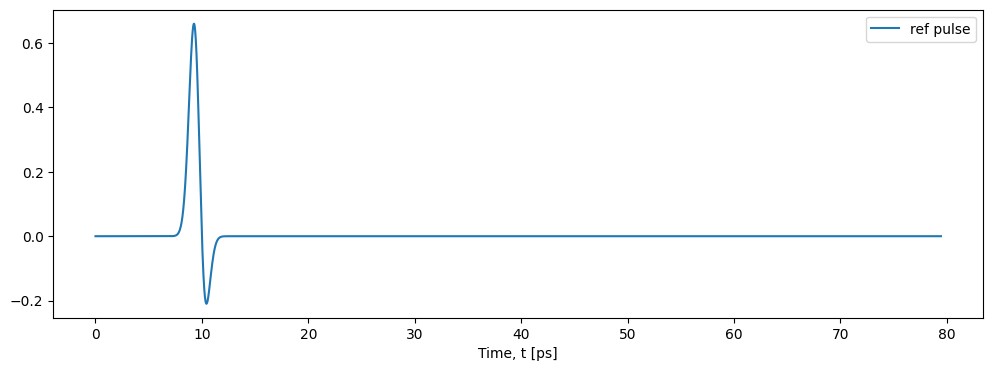

In [3]:
ref_path = 'data/example_ref_pulse.pulse.csv'
#ref_df = pd.read_csv(ref_path)
#t_axis = ref_df['Time_abs/ps'].to_numpy()
#reference_pulse = ref_df[' Signal/nA'].to_numpy()

## Remove Dc bias
#halfway = len(reference_pulse) // 2
# Calculate the mean of the second half (assumed baseline)
#bias = np.mean(reference_pulse[halfway:])
# Subtract the bias from the entire signal
#reference_pulse = reference_pulse - bias

L = len(reference_pulse)
print(f'Length of pulse array: {L}')
t_axis = np.arange(0, L * deltat, deltat)
#print(f'Bias: {bias}')
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [4]:
## Check time steps are consistent in t_axis

# Compute time differences between consecutive samples
dt = np.diff(t_axis)

# Check for uniform time step (within a small tolerance)
tolerance = 0.5e-12  # adjust as needed based on your signal's precision
is_uniform = np.all(np.abs(dt - dt[0]) < tolerance)

print("Time steps are uniform:", is_uniform)
if is_uniform:
    deltat = dt[0]
    print(f'delta_t: {deltat} ps')
if not is_uniform:
    print("Min dt:", np.min(dt))
    print("Max dt:", np.max(dt))
    print("Mean dt:", np.mean(dt))

Time steps are uniform: True
delta_t: 1.94e-14 ps


## Test Single layer simulated sample with experimental reference pulse

[((3.46-0.001j), 0.001)]


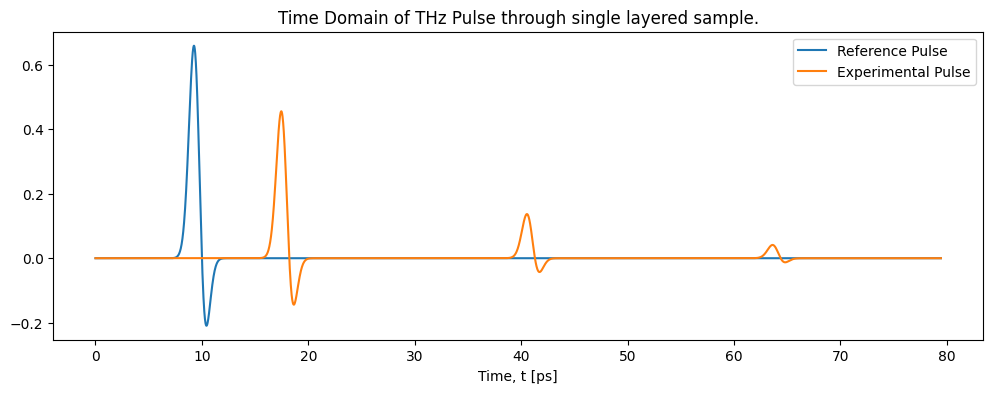

In [5]:
# Convert refence pulse to tensor
#reference_pulse = torch.tensor(reference_pulse, dtype=torch.float32)

# Convert delta_t to seconds from pico seconds
#deltat = deltat * 1e-12

# Material params
n1, k1, d1 = 3.46, -0.001, 1e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1)]

# Simulate the experimental data
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.title('Time Domain of THz Pulse through single layered sample.')
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

## Perform extraction on this data

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.3, 3.5)
Layer 1 - k ∈ (-0.0115, 0.0085)
Layer 1 - D ∈ (0.0008600000000000001, 0.00116)
[((3.4099232367007706-0.0115j), 0.0010167453773106936)]


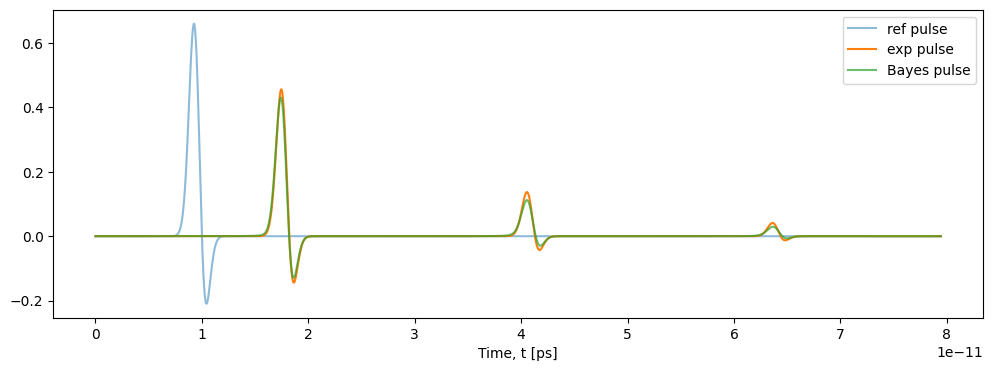

In [6]:
# set initial guesses for Bayes optimization
layers_init = [(3.4-0.0015j, 1.01e-3)]
# Set optimization mask
optimization_mask = [(True, True, True)]
Bayes_extractor = BayesianLayeredExtractor(reference_pulse,experimental_pulse, 
                                            deltat, layers_init, optimization_mask)

bayes_params = Bayes_extractor.bayesian_optimization(n_calls=50)
bayes_pulse = simulate_parallel(reference_pulse, bayes_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(bayes_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*, reference_pulse, label='ref pulse', alpha=0.5)
plt.plot(t_axis, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis, bayes_pulse, label='Bayes pulse', alpha=0.7)
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Fine-tuning 3 parameters for 50 iterations.
Iteration 4, Loss: 4.529260e-03, Layer 0: n=3.4104, k=-0.01100, D=1017.25 µm
Iteration 9, Loss: 4.296265e-03, Layer 0: n=3.4109, k=-0.01050, D=1017.69 µm
Iteration 14, Loss: 4.149561e-03, Layer 0: n=3.4112, k=-0.01000, D=1017.97 µm
Iteration 19, Loss: 4.021932e-03, Layer 0: n=3.4114, k=-0.00950, D=1018.01 µm
Iteration 24, Loss: 3.874346e-03, Layer 0: n=3.4115, k=-0.00900, D=1017.84 µm
Iteration 29, Loss: 3.724857e-03, Layer 0: n=3.4116, k=-0.00851, D=1017.61 µm
Iteration 34, Loss: 3.588902e-03, Layer 0: n=3.4117, k=-0.00802, D=1017.40 µm
Iteration 39, Loss: 3.457828e-03, Layer 0: n=3.4119, k=-0.00753, D=1017.29 µm
Iteration 44, Loss: 3.326662e-03, Layer 0: n=3.4121, k=-0.00705, D=1017.26 µm
Iteration 49, Loss: 3.201652e-03, Layer 0: n=3.4124, k=-0.00658, D=1017.22 µm
[((3.4124491214752197-0.006577627267688513j), 0.0010172211332246661)]


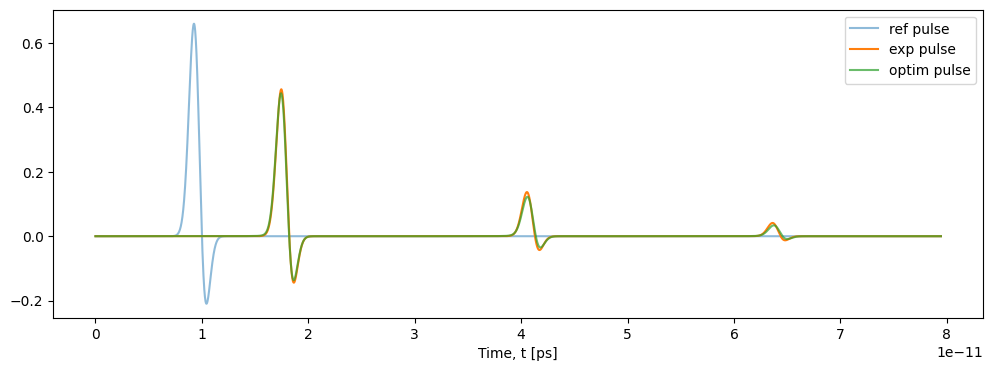

In [7]:
grad_optimizer = LayeredExtractor(reference_pulse, experimental_pulse, deltat, bayes_params, optimization_mask, lr=0.0001)
results = grad_optimizer.optimize(num_iterations=50, updates=5)

optim_params = [(results[0][0] + results[0][1]*1j, results[0][2])]

optim_pulse = simulate_parallel(reference_pulse, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis, reference_pulse, label='ref pulse', alpha=0.5)
plt.plot(t_axis, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis, optim_pulse, label='optim pulse', alpha=0.7)
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [8]:
print(f'n residual: {(3.46 - 3.459996223449707)}')
print(f'k residual: {(0.001 - 0.000995328649878502)}')

print(f'n % error: {100 * (3.46 - 3.459996223449707)/3.46}')
print(f'k % error: {100 * (0.001 - 0.000995328649878502)/0.001}')

n residual: 3.776550292933223e-06
k residual: 4.671350121498129e-06
n % error: 0.00010914885239691395
k % error: 0.46713501214981284


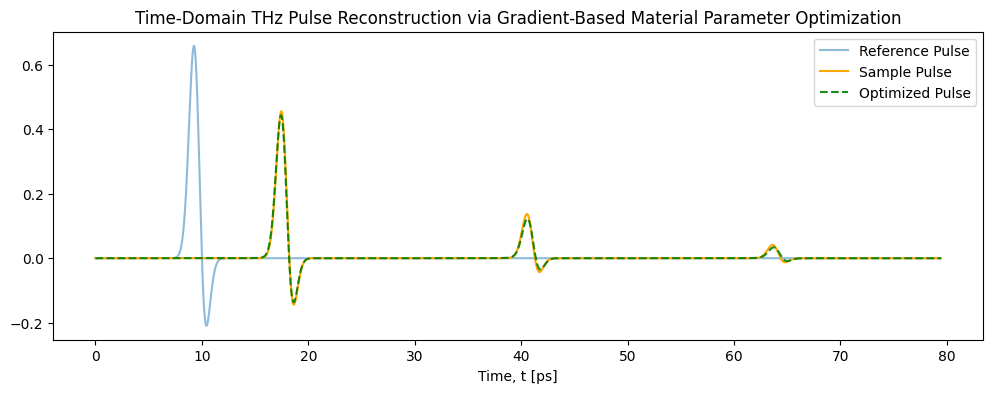

In [12]:
# Main figure
fig, ax = plt.subplots(figsize=(12, 4))

# Plotting
ax.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', alpha=0.5)
ax.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', color='orange')
ax.plot(t_axis*1e12, optim_pulse, label='Optimized Pulse', linestyle='--', color='green', alpha=0.9)

# Labels and title
ax.set_xlabel('Time, t [ps]')

ax.set_title('Time-Domain THz Pulse Reconstruction via Gradient-Based Material Parameter Optimization')
ax.legend()


plt.show()